<a href="https://colab.research.google.com/github/lagom-QB/M11/blob/master/Practice_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to notebooks and pytorch.
# Keywords: tensor, function, computational graph, gradient, backward propogation

# Notebook


If you want to use colab to work with the notebook, save it to your own google drive.

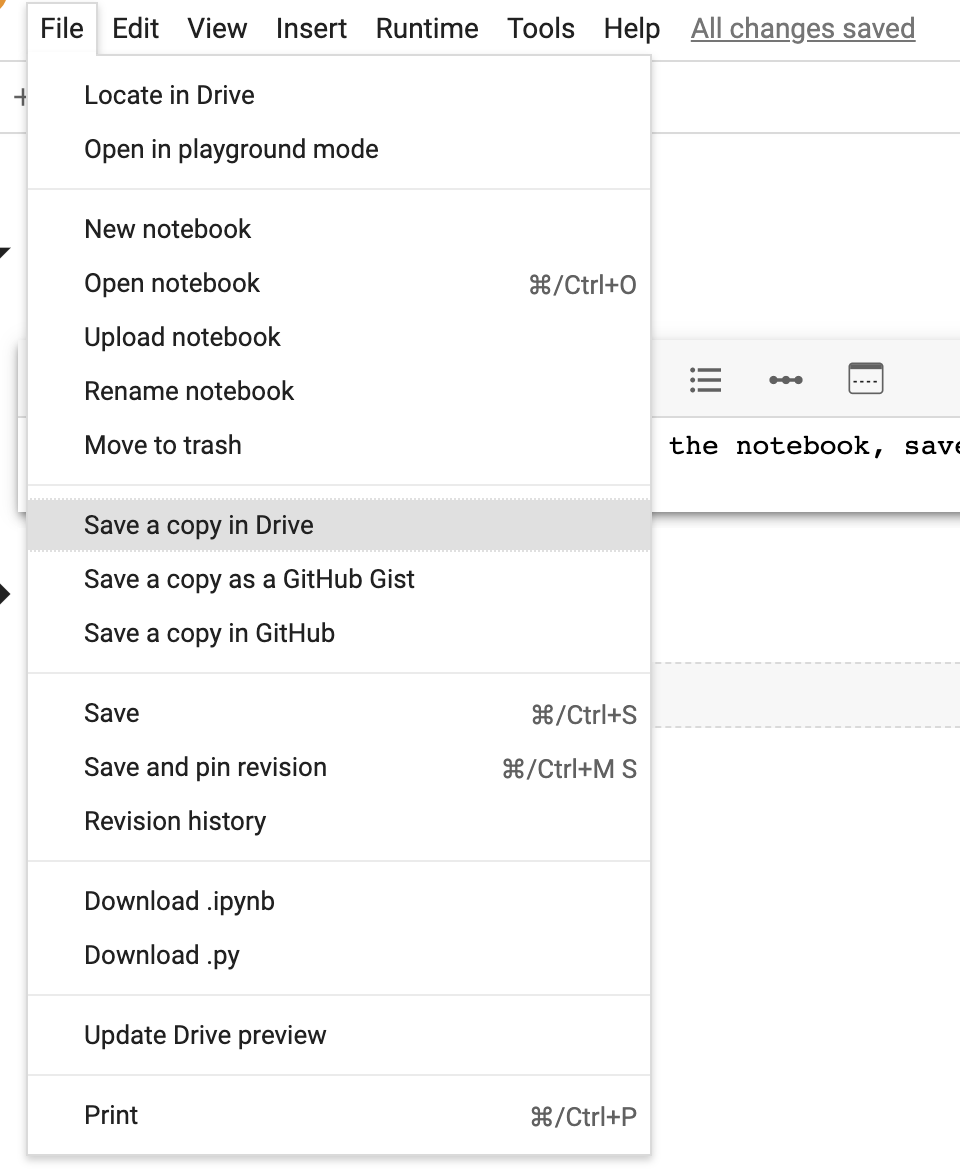

Open it and use your own copy.

If you want to work from the local machine, download the .ipynb file:


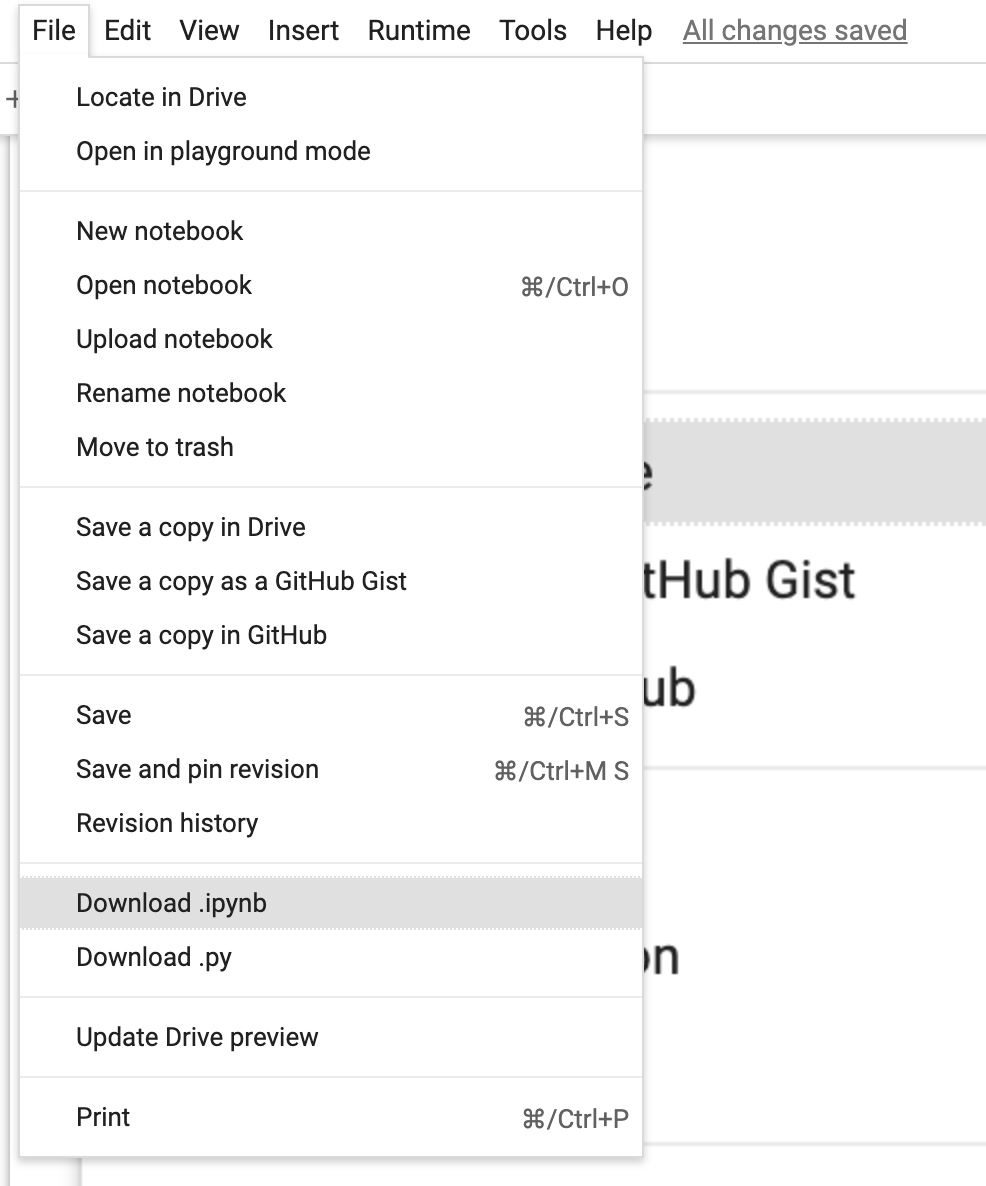

Install jupyter:

`pip install jupyter`

and start a local jupyter server:

`jupyter notebook path_to_downloaded_practice_1.ipynb`

this will open your default browser with the downloaded notebook. If you are asked for authorization token you can find it in the console where you started the jupyter.


# PyTorch

Let's check that environment is sane:

In [0]:
import torch

In [0]:
torch.__version__

### Can't import pytorch? [local]



If you are using local notebook then probably you don't have pytorch installed. You can install it from notebook:

In [0]:
!pip install torch

### pytorch version < 1.4? [local]

We'll need version 1.4+ for our practice. If your version is lower, you can upgrade with:

In [0]:
!pip install --upgrade torch

## Test hardware

In [0]:
torch.cuda.is_available()

### No GPU? [collab]

By default, google colab notebooks runs without hardware acceleration. To enable GPU we need to change runtime type: 

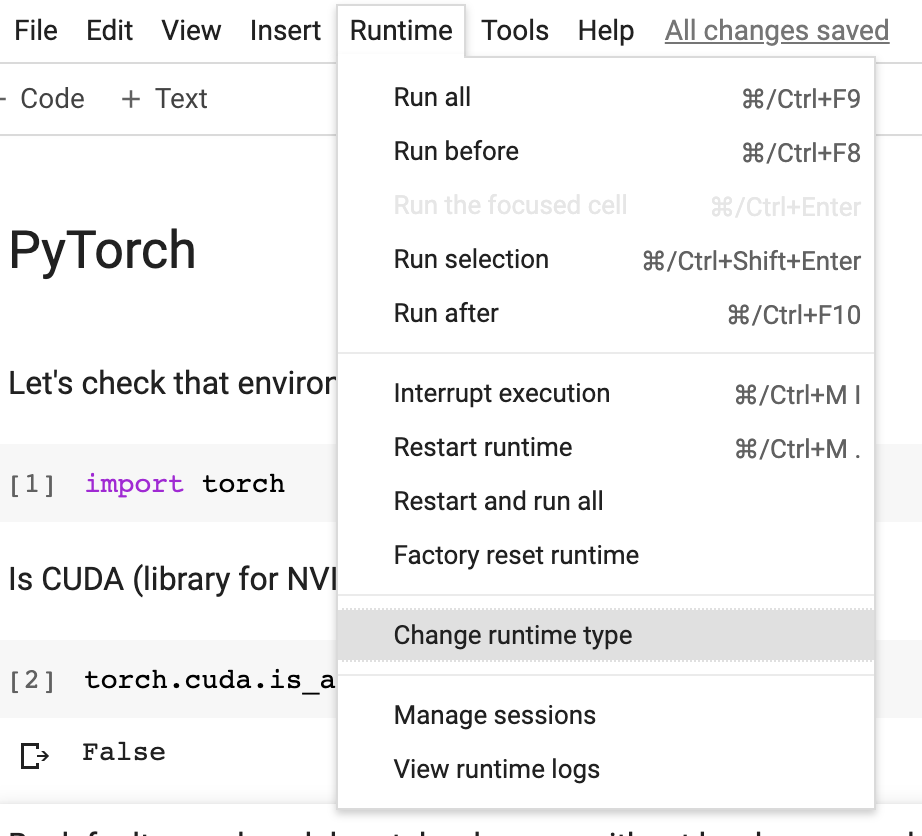

to GPU accelerator:

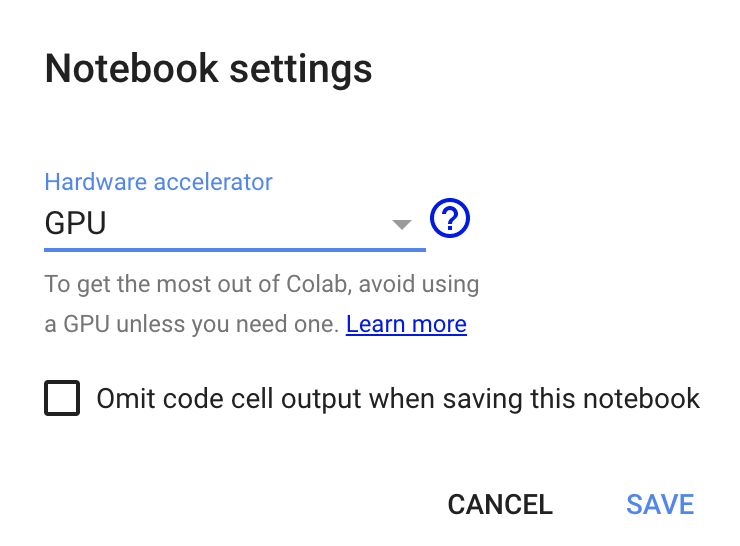

If you are using free google collab account, avoid using GPU when you don't need it. It's a limited resource and Google prioritizes users who haven't use GPU recently.

We don't need GPU today.

### No GPU? [local]

You need NVIDIA GPU card hardware as well as latest drivers and CUDA.
The easiest way to install pytorch with proper CUDA version is anaconda https://www.anaconda.com/products/individual:

In [0]:
!conda install pytorch torchvision cudatoolkit=10.1 -c pytorch -c defaults -c conda-forge


## Main concepts

#### Tensors
Tensors - objects and results of any computations.

In [0]:
x = torch.tensor([1.0, 2.0])
x

In [0]:
torch.zeros(10)

In [0]:
torch.ones(3)

#### Computational graph. 


Functions and tensors can be used to build a computational graph.

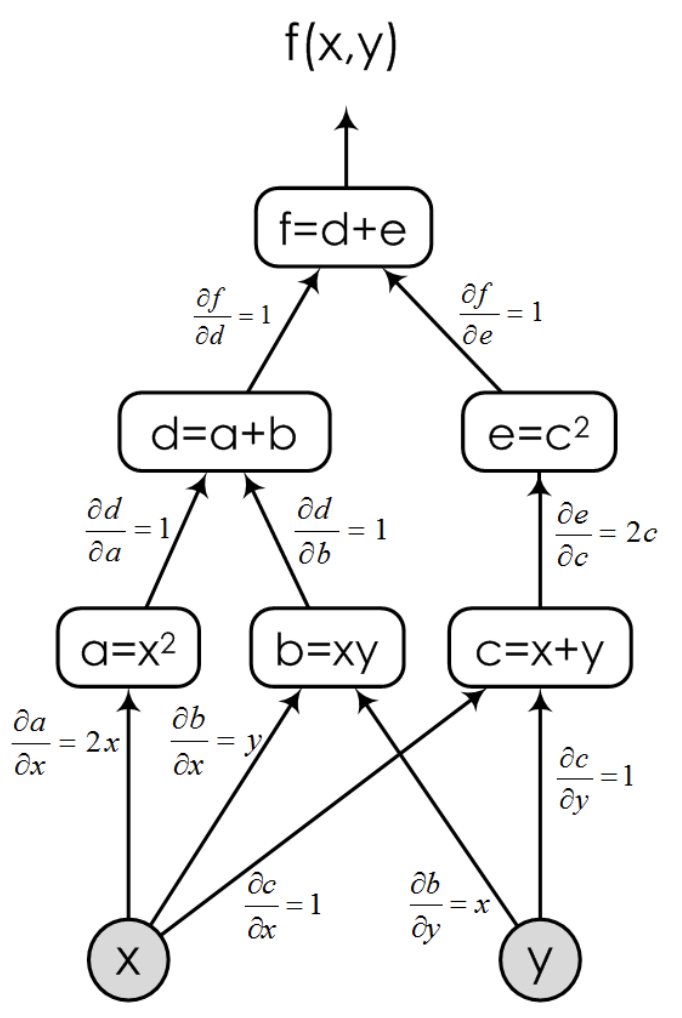

In pytorch, computational graphs are explicit (we did some computations above, but we never saw a computational graph).

#### Functions 
Functions - operations on tensors, which are combined in computation graph.

In [0]:
class MulConstant(torch.autograd.Function):
    # forward computes the function using inputs.
    @staticmethod
    def forward(ctx, 
                tensor: torch.FloatTensor, 
                constant: float) -> torch.FloatTensor:
        # ctx is a context object that can be used to stash information
        # for backward computation.
        ctx.constant = constant
        # Here we store constant in the context. Field name 'constant'
        # is arbitrary and we can use any name we want.
        return tensor * constant

    # backward compute derivatives during backward propagation. 
    # Its inputs are gradients of outputs.
    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor) -> torch.FloatTensor:
        # We return as many input gradients as there were arguments.
        # Gradients of non-Tensor arguments to forward must be None.
        return grad_output * ctx.constant, None

In [0]:
class Mul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, 
                tensor1: torch.FloatTensor, 
                tensor2: torch.FloatTensor) -> torch.FloatTensor:
        ctx.tensor1 = tensor1
        ctx.tensor2 = tensor2
        # We store values of both tensors as we will need them for 
        # backward propogation.
        return tensor1 * tensor2

    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor) -> torch.FloatTensor:
        # This time both inputs are tensors, so we compute gradients 
        # for both of them.
        return grad_output * ctx.tensor2, grad_output * ctx.tensor1

Usually there is no need to define functions, as torch already have a good built-in function library. Most of functions you'll need are already there or can be expressed as built-in functions composition. You can lookf for built-in functions in torch documentation here: https://pytorch.org/docs/stable/torch.html.

In [0]:
MulConstant.apply(x, 3)

Usually it's used like this:

In [0]:
mul_constant = MulConstant.apply
mul_constant(x, 3)

Using built-in functions:

In [0]:
torch.mul(x, 3)

Operator syntax:

In [0]:
x * 3

We can define new function, using python and built-in function library.



In [0]:
def power(tensor: torch.FloatTensor, exponent: int) -> torch.FloatTensor:
  result = torch.ones_like(tensor)
  for i in range(0, exponent):
    result *= tensor # same as result = torch.mul(result, tensor)
  return result

In [0]:
power(x, 2)

In [0]:
x = torch.tensor(2.0, requires_grad=True) # requires_grad shows that this is a graph "input"
y = torch.tensor(2.0, requires_grad=True)
a = x ** 2
b = x * y
c = x + y
d = a + b
e = c ** 2
f = d + e
f

Foward computation happened automatically, while we were building the graph. `grad_fn` means that `f` is not just a tensor, but has a computational graph associated with it (AddBackward means that the "topmost" operation of this graph is Add). And we can backward propagate to compute gradients.

### Autograd

The core of all ML frameworks is calculation of derivatives, using backward propagation.

In [0]:
f.backward()

In [0]:
x.grad

In [0]:
y.grad

Can we do this again?

In [0]:
f.backward()

Graph was already removed. Torch optimizes memory consumption and removes computational graph as soon as it is backward-propagated. Fortunately, error message is pretty clear, we can retain graph, by specifying `retain_graph=True` argument.

In [0]:
x = torch.tensor(2.0, requires_grad=True) # requires_grad shows that this is a graph "input"
y = torch.tensor(2.0, requires_grad=True)
a = x ** 2
b = x * y
c = x + y
d = a + b
e = c ** 2
f = d + e
f

In [0]:
f.backward(retain_graph=True)

In [0]:
x.grad

In [0]:
f.backward(retain_graph=True) 

In [0]:
x.grad

Gradient is `28`? Torch does not "clean" gradient value automatically (we'll find this pretty usefull later), so we must clean it manually.

In [0]:
x.grad = torch.tensor(0.0)

In [0]:
f.backward(retain_graph=True) 

In [0]:
x.grad

We can use this to compute gradients of any compositional function.

In [0]:
def f(x: torch.FloatTensor, y: torch.FloatTensor) -> torch.FloatTensor:
  a = x ** 2
  b = x * y
  c = x + y
  d = a + b
  e = c ** 2
  return d + e

In [0]:
x.grad = torch.tensor(0.0)
f(x, y).backward()
x.grad

The graph is rebuild each time we call the function, so we do not need to retain gradients.

In [0]:
x.grad = torch.tensor(0.0)
f(x, y).backward()
x.grad

# Assignment [10]

* 30% - Home work asigment [~ 10 points a day, ~ 120 total]

* 20% - Mid term test

* 20% - Final Exam

* 30% - Course projects (can be replaced by bonus homework)

## Due to 10AM, 19.05.2020

##1. Power function [5] 

Implement int power of FloatTensor autograd function, using addition and multiplication. [3]

In [0]:
class Power(torch.autograd.Function):
    @staticmethod
    def forward(...):
        ...

    @staticmethod
    def backward(...):
        ...

Test that it is correct:

In [0]:
assert(torch.all(Power.apply(torch.tensor([1, 2, 3]), 0) == torch.tensor([1,1,1])))
# Note that tensors comparision returns tensor with elementwise comparisions
# [1,2,3] == [1,1 1] returns [True, False, False].
# Thus we use torch.all to reduce it to a single boolean value.
# torch.all(x) is true only if all elements of x are True.

In [0]:
assert(torch.all(Power.apply(torch.tensor([1, 2, 3]), 2) == torch.tensor([1,4,9])))

Test that gradients are computed correctly (even for composite functions, using Power). [1]

In [0]:
... # gradient tests

By defining `Power` class we introduced a new building block which can be used in computational graph.
Computational graph for `Power.apply(x, 3)` has just three vertices, `x`, constant `3` and `Power`.
We introduce function `power` in the class. 
How does computational graph for `power(x, 3)` look? 
(hint: we used only two types of building blocks, `*` and `torch.ones_like`) [1]

## 2. Polynom [5]

Find zero of the following polynom with up to five decimal places:

In [0]:
def poly(x: torch.FloatTensor) -> torch.FloatTensor:
  return x**7 + 5 * x**3  + 17 * x -9

Using binary search https://en.wikipedia.org/wiki/Binary_search_algorithm [2]:

In [0]:
from typing import Callable

In [0]:
def bin_search_find_zero(poly: Callable[[torch.FloatTensor], 
                                        torch.FloatTensor]) -> torch.FloatTensor:
  ...

Using Newton's method https://en.wikipedia.org/wiki/Newton%27s_method [2]
(hint: use backward to compute derivatives):


In [0]:
def newton_find_zero(poly: Callable[[torch.FloatTensor], 
                                    torch.FloatTensor]) -> torch.FloatTensor:
  ...

Test, which of this methods is faster. [1]
You can do this using `%%time` notebook command.



In [0]:
%%time 
2 + 3

In [0]:
... # bin_search_test

In [0]:
... # newton_test

For more accurate comparision you may want to use `%%timeit` notebook command.

In [0]:
%%timeit -n 100 -r 10
2+3

In [0]:
...